In [18]:
#pip install --upgrade Pillow

In [2]:
from __future__ import absolute_import, division, print_function
import cv2
import math
import matplotlib.pyplot as plt
%matplotlib inline
from skimage.filters import threshold_otsu
import numpy as np
import pandas as pd
from glob import glob
import scipy.misc
import tensorflow as tf
from matplotlib.patches import Circle,Ellipse
from matplotlib.patches import Rectangle
import os
from PIL import Image, ImageFilter
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
import skimage
%matplotlib inline
from keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import BatchNormalization
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from skimage.morphology import convex_hull_image, erosion
from skimage.morphology import square
#https://www.geeksforgeeks.org/os-walk-python/
os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"
dataset_dir = 'fingerprintdataset2'
for dirname, dirnames, filenames in os.walk(dataset_dir):
    for filename in filenames:
        print(os.path.join(dirname, filename))




fingerprintdataset2/fingerprints/DB1_B/101_1.tif
fingerprintdataset2/fingerprints/DB1_B/101_2.tif
fingerprintdataset2/fingerprints/DB1_B/101_3.tif
fingerprintdataset2/fingerprints/DB1_B/101_4.tif
fingerprintdataset2/fingerprints/DB1_B/101_5.tif
fingerprintdataset2/fingerprints/DB1_B/101_6.tif
fingerprintdataset2/fingerprints/DB1_B/101_7.tif
fingerprintdataset2/fingerprints/DB1_B/101_8.tif
fingerprintdataset2/fingerprints/DB1_B/102_1.tif
fingerprintdataset2/fingerprints/DB1_B/102_2.tif
fingerprintdataset2/fingerprints/DB1_B/102_3.tif
fingerprintdataset2/fingerprints/DB1_B/102_4.tif
fingerprintdataset2/fingerprints/DB1_B/102_5.tif
fingerprintdataset2/fingerprints/DB1_B/102_6.tif
fingerprintdataset2/fingerprints/DB1_B/102_7.tif
fingerprintdataset2/fingerprints/DB1_B/102_8.tif
fingerprintdataset2/fingerprints/DB1_B/103_1.tif
fingerprintdataset2/fingerprints/DB1_B/103_2.tif
fingerprintdataset2/fingerprints/DB1_B/103_3.tif
fingerprintdataset2/fingerprints/DB1_B/103_4.tif
fingerprintdataset2/

In [3]:
import imageio
#https://docs.python.org/3/library/glob.html
data = glob('fingerprintdataset2/fingerprints/DB*/*')
images = []
from matplotlib.pyplot import imread
def readImages(data):
    for i in range(len(data)):
        #loads image from the files 
        #https://www.geeksforgeeks.org/python-opencv-cv2-imread-method/
        img = cv2.imread(data[i],0)
        #resizes them to 224 by 224
        img = cv2.resize(img,(224,224))
        images.append(img)
        
    return images
#returns new list of resized images
images = readImages(data)

Display random images from dataset


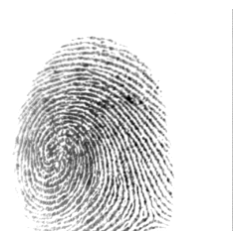

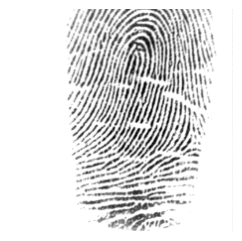

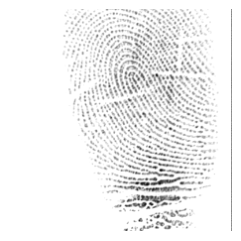

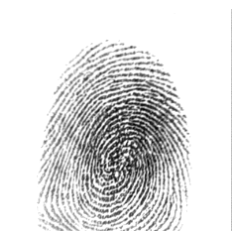

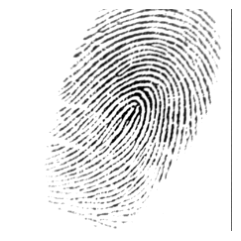

In [47]:
def plot_images(images):
    print("Display random images from dataset")
    for i in range(5):
        #https://matplotlib.org/stable/api/
        #create a 12 pixel by 12 pixel window
        plt.figure(figsize = (12,12))
                #specifies where to put the image
        plt.subplot(5, 5, i+1)
        plt.set_cmap('gray')
        plt.imshow(images[i])
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        
plot_images(images)

**Add gaussian noise to dataset**

In [48]:
imp_noise=np.zeros((224,224),dtype=np.uint8)
cv2.randu(imp_noise,0,255)
imp_noise=cv2.threshold(imp_noise,100,255,cv2.THRESH_BINARY)[1]

Display random images from dataset


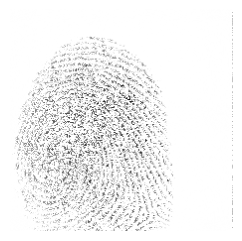

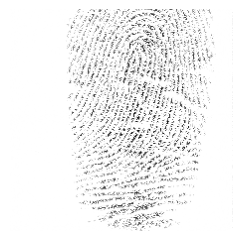

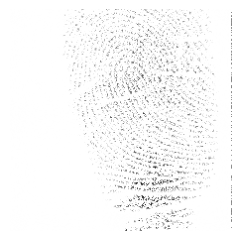

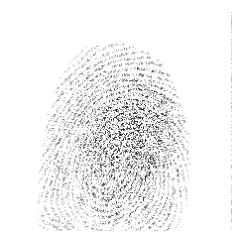

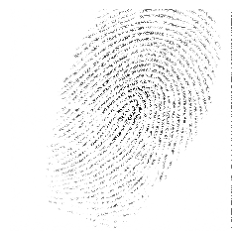

In [49]:
noisy_images = []
from matplotlib.pyplot import imread
def generateNoisyImages(data):
    for i in range(len(data)):
        #loads image from the files 
        #https://www.geeksforgeeks.org/python-opencv-cv2-imread-method/
        in_img=cv2.add(images[i],imp_noise)
        #resizes them to 224 by 224
        noisy_images.append(in_img)
        
    return noisy_images
#returns new list of resized images
noisy_images = generateNoisyImages(images)
plot_images(noisy_images)

In [52]:
images_arr = np.asarray(images)
images_arr = images_arr.astype('float32')
noisy_images_arr = np.asarray(noisy_images)
noisy_images_arr = noisy_images_arr.astype('float32')
#shape that returns a tuple with each index having the number of corresponding elements.
#The shape of the fingerprint images in the FingerDataset2 dataset is (320, 224, 224, 3). 
#This means that there are 320 images, 224 pixels by 224 pixels with each image having 3 channels.
images_arr.shape, noisy_images_arr.shape

((320, 224, 224), (320, 224, 224))

In [53]:
#reshape images 
#first dimension is unspecified, 2nd and third dimensions are kept the same, channels reduced to 1
images_arr = images_arr.reshape(-1, 224,224, 1)
noisy_images_arr = noisy_images_arr.reshape(-1, 224,224, 1)
images_arr.shape, noisy_images_arr.shape

((320, 224, 224, 1), (320, 224, 224, 1))

In [54]:
images_arr.dtype, noisy_images_arr.dtype

(dtype('float32'), dtype('float32'))

In [55]:
#normalise
np.max(images_arr)
np.max(noisy_images_arr)
images_arr = images_arr / np.max(images_arr)
noisy_images_arr = noisy_images_arr / np.max(noisy_images_arr)

In [56]:
#check normalised range is correct
np.max(images_arr), np.min(images_arr), np.max(noisy_images_arr), np.min(noisy_images_arr) 


(1.0, 0.0, 1.0, 0.0)

In [57]:
#80% train test split
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(noisy_images_arr,images_arr,test_size=0.2,random_state=12)

In [58]:
batch_size = 4
epochs = 200
x, y = 224, 224
#https://keras.io/api/layers/core_layers/input/
input_img = Input(shape = (x, y, 1))

In [59]:
def autoencoder(input_img):
    #32 3 x 3 filters with zero padding, stride 1 
    conv1 = Conv2D(32,(3,3), activation='relu', padding='same')(input_img)
    #max pooling of 2x2
    pool1 = MaxPooling2D(pool_size=(2,2))(conv1) 
    conv2 = Conv2D(64,(3,3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2,2))(conv2) 
    conv3 = Conv2D(128,(3,3), activation='relu', padding='same')(pool2)
    conv4 = Conv2D(128,(3,3), activation='relu', padding='same')(conv3)
    #decode - upsampling
    up1 = UpSampling2D((2,2))(conv4)
    conv5 = Conv2D(64,(3,3), activation='relu', padding='same')(up1)
    up2 = UpSampling2D((2,2))(conv5)
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2)
    return decoded
#Add checkpoints to save the weights in case kernel dies
checkpoint_path = "checkpoints/"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = keras.callbacks.ModelCheckpoint(checkpoint_path,save_weights_only=True, verbose=1)
autoencoder = Model(input_img, autoencoder(input_img))

In [60]:
!ls {checkpoint_dir}

checkpoint


In [61]:
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop())

In [62]:
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 128)       7385

In [63]:

autoencoder_train = autoencoder.fit(train_X,train_ground,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(valid_X, valid_ground),callbacks=[cp_callback])

Epoch 1/200
64/64 [==============================] - ETA: 0s - loss: 0.0602
Epoch 1: saving model to checkpoints/
64/64 [==============================] - 8s 120ms/step - loss: 0.0602 - val_loss: 0.0269
Epoch 2/200
64/64 [==============================] - ETA: 0s - loss: 0.0248
Epoch 2: saving model to checkpoints/
64/64 [==============================] - 7s 109ms/step - loss: 0.0248 - val_loss: 0.0163
Epoch 3/200
64/64 [==============================] - ETA: 0s - loss: 0.0205
Epoch 3: saving model to checkpoints/
64/64 [==============================] - 7s 114ms/step - loss: 0.0205 - val_loss: 0.0170
Epoch 4/200
64/64 [==============================] - ETA: 0s - loss: 0.0183
Epoch 4: saving model to checkpoints/
64/64 [==============================] - 7s 114ms/step - loss: 0.0183 - val_loss: 0.0157
Epoch 5/200
64/64 [==============================] - ETA: 0s - loss: 0.0180
Epoch 5: saving model to checkpoints/
64/64 [==============================] - 7s 114ms/step - loss: 0.0180 - va

<Figure size 640x480 with 0 Axes>

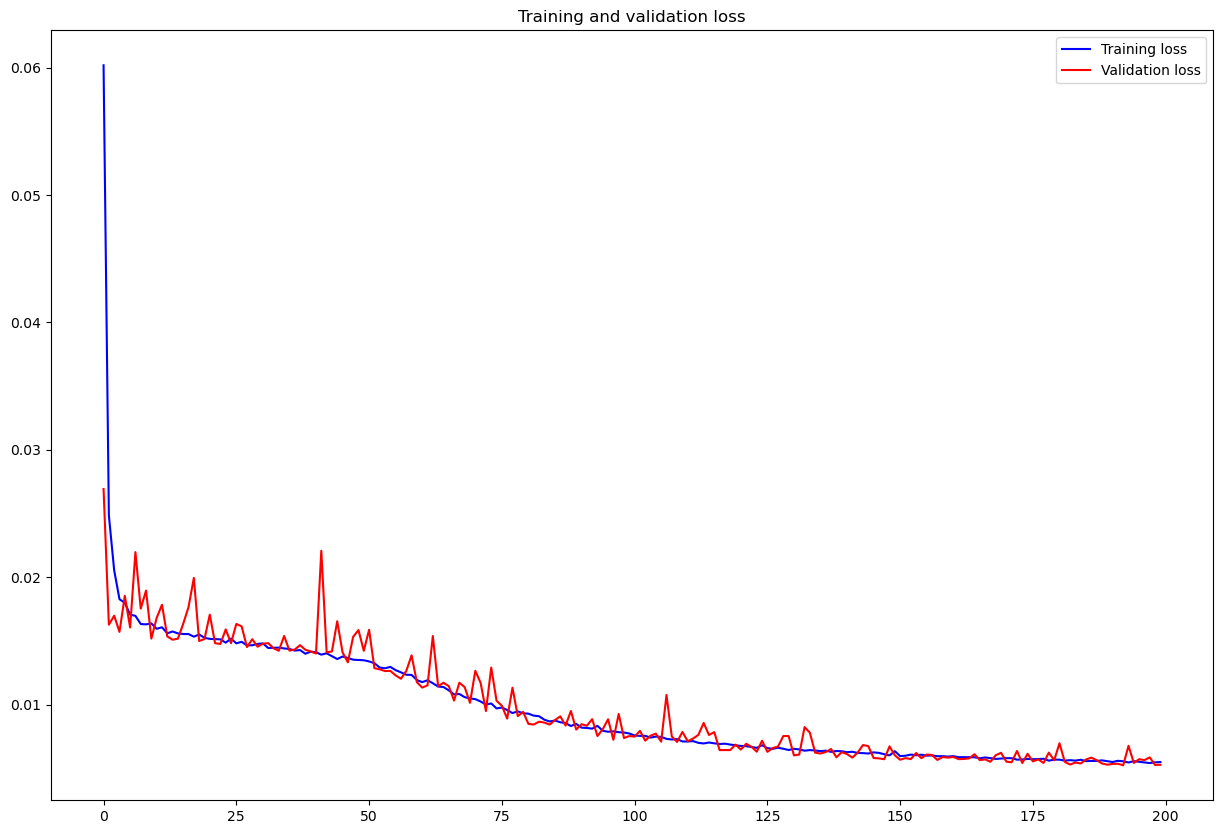

In [64]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(200)
plt.figure()
plt.figure(figsize=(15,10))
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

8/8 [==============================] - 2s 280ms/step
Test Images


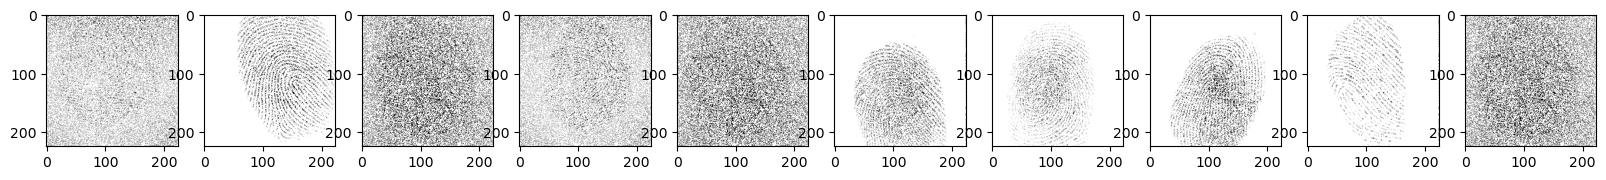

Reconstruction of Test Images


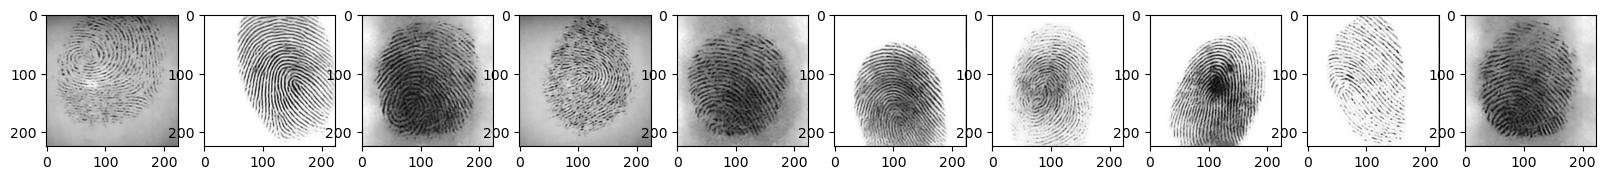

In [68]:
#Prediction
pred = autoencoder.predict(train_X)#Reconstruction of Test Images
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_X[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()

In [24]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

'checkpoints/.'

In [69]:
autoencoder.save('my_model.h5')

/home/monkescripts/.local/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [70]:
new_model = keras.models.load_model('my_model.h5')
new_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_6 (Conv2D)           (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 56, 56, 128)       7385

8/8 [==============================] - 2s 281ms/step
Test Images


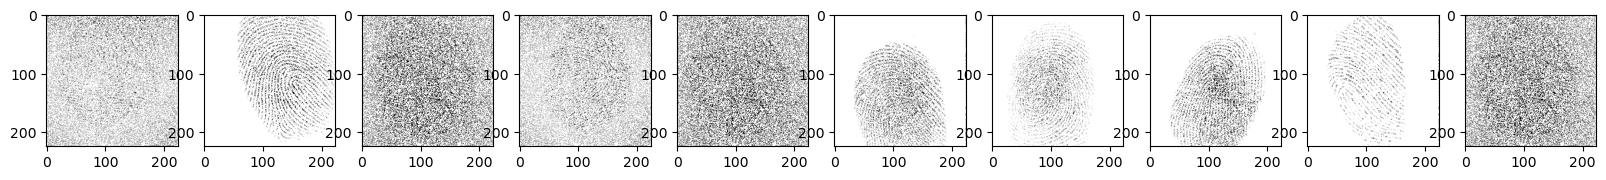

Reconstruction of Test Images


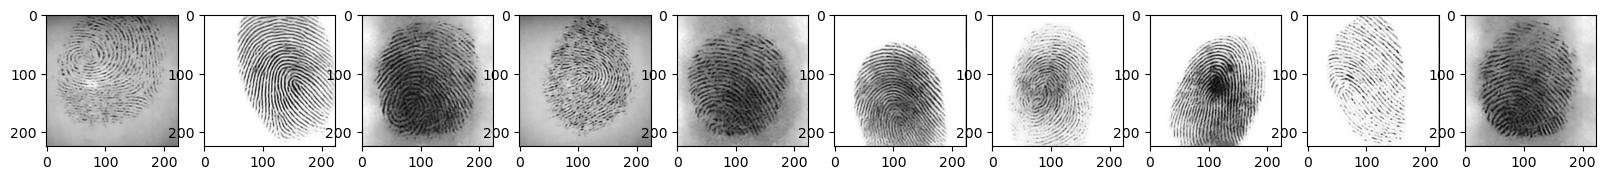

In [76]:
#Prediction
new_model = keras.models.load_model('my_model.h5')
pred = new_model.predict(train_X)#Reconstruction of Test Images
plt.figure(figsize=(20, 4))
print("Test Images")
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(train_X[i, ..., 0], cmap='gray')
plt.show()    
plt.figure(figsize=(20, 4))
print("Reconstruction of Test Images")
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(pred[i, ..., 0], cmap='gray')  
plt.show()